In [1]:
%load_ext autoreload
%autoreload 1
%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}

In [2]:
import pandas as pd
import numpy as np
from torch.utils.data import DataLoader
import timm
from timm import optim, scheduler
import torch
from torchvision import transforms as tfm
from sklearn import metrics as skmet
import matplotlib.pyplot as plt
import json
import transforms as my_transforms

%aimport dataset
%aimport models
VideoClassifier = models.VideoClassifier
VideoData = dataset.VideoData

In [3]:
artifact_folder = '/zfs/wficai/pda/model_run_artifacts/20220818_no2d_224x224'
# artifact_folder = '/zfs/wficai/pda/model_run_artifacts/20220818_all_224x224'

with open(artifact_folder + '/config_video.json', 'r') as f: 
    cfg = json.load(f)

# put all config variables in scope to avoid the need to laboriously index cfg
for k, v in cfg.items():
    v = f"'{v}'" if type(v)==str else v
    exec(f"{k}={v}")
del cfg

In [4]:
# optionally override the view/mode filters
view_filter = ['pdaView', 'pdaRelatedView']
mode_filter = ['2d', 'color', 'color_compare']

In [5]:
tfms = my_transforms.VideoTransforms(res)
tfms_test = tfms.get_transforms(transforms['test'])

In [6]:
device = torch.device('cuda:0')  # you may need 'cuda:0' 'cpu'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device


device(type='cuda')

In [7]:
df_test = pd.read_csv(f'{artifact_folder}/{out_paths["test"]}')
d_test = VideoData(df_test, transforms = tfms_test, mode_filter = mode_filter, view_filter = view_filter)
dl_test = DataLoader(d_test, batch_size=bs_test, num_workers=num_workers, collate_fn = VideoData.collate)

print("Number of frames after filtering:", len(d_test.data))

Number of frames after filtering: 16973


/home/spandir/.conda/envs/pda/lib/python3.9/site-packages/torch/utils/data/dataloader.py:563: UserWarning: This DataLoader will create 30 worker processes in total. Our suggested max number of worker in current system is 20, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [8]:
# create frame model

m_frames = timm.create_model(model, num_classes=num_classes, in_chans=3, drop_rate=dropout)

_ = m_frames.to(device)

# create video model
m = VideoClassifier(m_frames)

# load checkpoint
m.load_state_dict(torch.load(f"{artifact_folder}/model_checkpoint_video.ckpt"))

<All keys matched successfully>

In [9]:
m_frames_trained = m.get_frame_classifier()

In [10]:
loss_function = torch.functional.F.binary_cross_entropy_with_logits

target_ls = []
output_ls = []
study_ls = []
mask_ls = []
externalid_ls = []
view_ls = []
mode_ls = []
losses = []
attn_ls = []

for ix, batch in enumerate(dl_test):
    print(f"Batch {ix+1}", end = "\r")
    vid = batch['video'].to(device)
    mask = batch['mask'].to(device)
    targets = batch['trg_type'].to(device).type(torch.float32)
    
    target_ls.append(targets.cpu().numpy())
    view_ls.append(batch['trg_view'].numpy())
    mode_ls.append(batch['trg_mode'].numpy())
    study_ls += batch['study']
    mask_ls.append(batch['mask'].numpy())
    externalid_ls += batch['external_id']

    with torch.no_grad():
        outputs, attn = m(vid, mask)
        output_ls.append(outputs.cpu().numpy())
        attn_ls.append(attn.cpu().numpy())
        loss = loss_function(outputs.squeeze(), targets)
        losses.append(loss.detach().item())

In [11]:
df_results = pd.DataFrame(dict(
    study = study_ls,
    external_id = externalid_ls,
    predicted = np.concatenate(output_ls).squeeze(),
    target = np.concatenate(target_ls), 
    mode = np.concatenate(mode_ls),
    view = np.concatenate(view_ls)
))

df_results['mode'] = df_results['mode'].map(VideoData.inv_mode_map)
df_results.view = df_results.view.map(VideoData.inv_view_map)

df_results.head(20)

,study,external_id,predicted,target,mode,view
0,study24,study24_dicom67,0.310564,0.0,2d,pdaRelatedView
1,study24,study24_dicom98,0.056878,0.0,color_compare,pdaRelatedView
2,study24,study24_dicom85,0.008938,0.0,2d,pdaRelatedView
3,study24,study24_dicom117,0.086215,0.0,color,pdaView
4,study24,study24_dicom118,0.017339,0.0,2d,pdaRelatedView
5,study24,study24_dicom108,0.002014,0.0,2d,pdaRelatedView
6,study24,study24_dicom116,0.003237,0.0,2d,pdaRelatedView
7,study24,study24_dicom110,0.013123,0.0,color_compare,pdaRelatedView
8,study10,study10_dicom51,0.004769,0.0,2d,pdaRelatedView
9,study10,study10_dicom32,0.030856,0.0,2d,pdaRelatedView


In [12]:
def compute_metrics(y_true, y_pred, thresh=0.5):
    mets = dict()
    
    y_pred_cls = (y_pred>thresh).astype(int)
    
    mets['num_samples'] = len(y_true)
    mets['roc_auc'] = skmet.roc_auc_score(y_true, y_pred)
    mets['average_precision'] = skmet.average_precision_score(y_true, y_pred)
    mets['accuracy'] = skmet.accuracy_score(y_true, y_pred_cls)
    mets['sensitivity'] = skmet.recall_score(y_true, y_pred_cls)
    mets['specificity'] = skmet.recall_score(y_true, y_pred_cls, pos_label=0)
    
    return mets

# Clip-level results

In [13]:
compute_metrics(df_results.target, df_results.predicted)

{'num_samples': 171,
 'roc_auc': 0.731029810298103,
 'average_precision': 0.7209942063319165,
 'accuracy': 0.8538011695906432,
 'sensitivity': 0.5208333333333334,
 'specificity': 0.983739837398374}

In [14]:
grouped_results = df_results.groupby(['view', 'mode']).apply(lambda dat: compute_metrics(dat.target, dat.predicted))
grouped_results = pd.DataFrame(grouped_results.tolist(), index=grouped_results.index)
grouped_results

num_samples   roc_auc  average_precision  \
view           mode                                                      
pdaRelatedView 2d                      50  0.610119           0.240798   
               color                   21  0.685185           0.716667   
               color_compare           31  0.989130           0.975000   
pdaView        2d                      18  0.740741           0.807308   
               color                   18  1.000000           1.000000   
               color_compare           33  0.925926           0.955303   

                              accuracy  sensitivity  specificity  
view           mode                                               
pdaRelatedView 2d             0.820000     0.000000     0.976190  
               color          0.904762     0.333333     1.000000  
               color_compare  0.935484     0.750000     1.000000  
pdaView        2d             0.500000     0.000000     1.000000  
               color          0.944444     1.000000     0.923077  
               color_compare  0.939394     0.866667     1.000000

# Attention

In [15]:
df_results.query('target==0.0 and mode=="color" and view=="pdaView"')

,study,external_id,predicted,target,mode,view
3,study24,study24_dicom117,0.086215,0.0,color,pdaView
27,study69,study69_dicom94,0.080548,0.0,color,pdaView
38,study27,study27_dicom62,0.063352,0.0,color,pdaView
46,study59,study59_dicom113,0.112623,0.0,color,pdaView
86,study2,study2_dicom3,0.172214,0.0,color,pdaView
97,study37,study37_dicom96,0.136930,0.0,color,pdaView
101,study37,study37_dicom84,0.034183,0.0,color,pdaView
135,study57,study57_dicom61,0.103025,0.0,color,pdaView
149,study32,study32_dicom83,0.008928,0.0,color,pdaView
156,study28,study28_dicom28,0.144246,0.0,color,pdaView


In [16]:
index = 10
batch_ix = index // bs_test
ix_in_batch = index % bs_test

mask = mask_ls[batch_ix][...,ix_in_batch]
attn = attn_ls[batch_ix][...,ix_in_batch]
trg_type = int(target_ls[batch_ix][ix_in_batch])
target = VideoData.inv_type_map[trg_type]
view = VideoData.inv_view_map[int(view_ls[batch_ix][ix_in_batch])]
external_id = externalid_ls[index]

mp4_path = df_test.loc[(df_test.external_id == external_id) & (df_test.trg_type == trg_type)].mp4_path.unique().item()
mp4_path = mp4_path.replace('/Superior Views/', '/superior_views_h264/')

print(external_id, target, view, sep=' - ')

study10_dicom50 - nopda - pdaRelatedView


(0.0, 0.1)

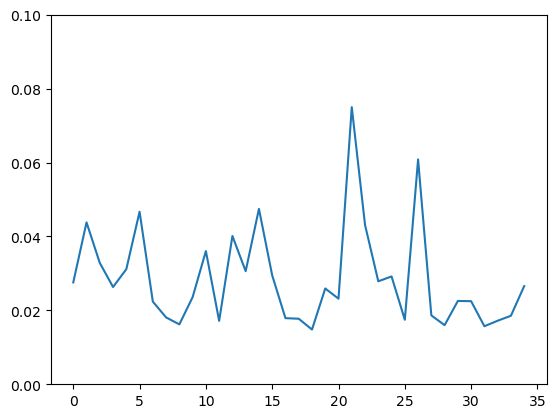

In [17]:
plt.plot(attn[mask])
plt.ylim(0,0.1)

In [18]:
# from IPython.display import FileLink
# !cp $mp4_path /home/dane2/Code/pda_detection/